# Analytics for Unstructured Data Homework 1

## Group members
Stephanie Coutts

Zachary Garland

Darius Hajibashi

Keenan Hui

Dohyung Kim

Gabriel Sanders

Raghu Subramanian



## Web Scraping


In [96]:
!pip install selenium webdriver_manager

In [97]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException, TimeoutException
import time
import csv
import os

def execute_if_not_exists(filename, code_function):
    if os.path.exists(filename):
        print(f"{filename} already exists. Skipping execution.")
        return False
    else:
        print(f"{filename} doesn't exist. Executing code...")
        code_function()
        return True


# Config
FORUM_URL = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p{}'
CSV_OUTPUT = 'edmunds_entry_level_luxury_posts.csv'
NUM_POSTS_DESIRED = 10000
WAIT_BETWEEN_PAGES = 2  # seconds

In [98]:
import os
from pathlib import Path

# Check if CSV output file already exists
if Path(CSV_OUTPUT).exists():
    print(f"{CSV_OUTPUT} already exists. Skipping web scraping.")
else:
    print(f"{CSV_OUTPUT} doesn't exist. Starting web scraping...")
    
    # Selenium options with headless
    chrome_options = Options()
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument('--blink-settings=imagesEnabled=false')
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--window-size=1920,1080")
    driver = webdriver.Chrome(options=chrome_options)

    results = []
    collected_posts = 0
    page = 1

    # Running with a try catch exception to validate existing logic
    try:
        while collected_posts < NUM_POSTS_DESIRED:
            url = FORUM_URL.format(page)
            print(f"Scraping page {page} ...")
            driver.get(url)
            time.sleep(WAIT_BETWEEN_PAGES)  # Need to validate if this interval is enough, so far so good

            # Need to find all post containers, have to verify class if Edmunds changes HTML)
            posts = driver.find_elements(By.CSS_SELECTOR, "div.Message")
            if not posts:
                print("No posts found, stopping.")
                break

            for post in posts:
                # Try to get userid
                try:
                    username = post.find_element(By.XPATH, ".//preceding::a[contains(@class, 'Username')][1]").text.strip()
                except NoSuchElementException:
                    username = "Unknown"

                # Try to get date
                try:
                    date_tag = post.find_element(By.XPATH, ".//preceding::time[1]")
                    date = date_tag.get_attribute('datetime') or date_tag.text.strip()
                except NoSuchElementException:
                    date = ""

                # Getting rid of the content to avoid double-counting quoted messages
                # Only extract each user's new content
                driver.execute_script("""
                  let el = arguments[0];
                  let quotes = el.querySelectorAll('blockquote');
                  quotes.forEach(function(q){ q.remove(); });
                """, post)

                # Extract message (post text sans any quoted material)
                message = post.text.strip()
                if not message:
                    continue

                results.append({"userid": username, "date": date, "message": message})
                collected_posts += 1
                if collected_posts >= NUM_POSTS_DESIRED:
                    break

            page += 1

    finally:
        driver.quit()
    #"""
    # Write output to CSV
    with open(CSV_OUTPUT, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=['userid', 'date', 'message'])
        writer.writeheader()
        for row in results:
            writer.writerow(row)

    print(f"Saved {len(results)} posts to {CSV_OUTPUT}")
    #"""

edmunds_entry_level_luxury_posts.csv already exists. Skipping web scraping.


In [99]:
import pandas as pd
import numpy as np
import os

raw_path  = "edmunds_entry_level_luxury_posts.csv"
clean_path = "edmunds_entry_level_luxury_posts_cleaned.csv"

df = pd.read_csv(raw_path, dtype=str, header=0, on_bad_lines="skip")

# sometimes the scraper spits out one glued column like "useriddatemessage0"
# if that happens, try re-reading as if there were no header and assign the right names
if df.shape[1] == 1 and df.columns[0].lower() not in {"userid","date","message"}:
    df = pd.read_csv(raw_path, dtype=str, header=None,
                     names=["userid","date","message"],
                     on_bad_lines="skip")

# make sure we always have userid, date, and message columns (create if missing)
for col in ["userid","date","message"]:
    if col not in df.columns:
        df[col] = np.nan
df = df[["userid","date","message"]]

# sometimes header lines get written into the data itself
mask_header_rows = (
    df["userid"].str.lower().eq("userid") |
    df["date"].str.lower().eq("date") |
    df["message"].str.lower().eq("message")
)
df = df[~mask_header_rows].copy()

# strip extra whitespace and drop rows with empty or missing messages
for c in ["userid","date","message"]:
    df[c] = df[c].astype(str).str.strip()
df = df.replace({"": np.nan})
df = df.dropna(subset=["message"]).query("message.str.len() > 0", engine="python").copy()

# try to parse the date column to something consistent; fall back if parsing fails
parsed_date = pd.to_datetime(df["date"], errors="coerce", utc=True)
if parsed_date.notna().any():
    df["date_parsed"] = parsed_date
    df["date"] = df["date_parsed"].dt.strftime("%Y-%m-%d %H:%M:%S%z").fillna(df["date"])
    df = df.drop(columns=["date_parsed"])

# drop exact duplicates and near-duplicates based on all three key columns
df = df.drop_duplicates()
df = df.drop_duplicates(subset=["userid","date","message"])

# save the cleaned file so it can be reused downstream
os.makedirs(os.path.dirname(clean_path) or ".", exist_ok=True)
df.to_csv(clean_path, index=False)

print(f"cleaned rows: {len(df):,}")
df.head(5)

cleaned rows: 10,000


,userid,date,message
0,cybersol,2002-03-23 19:04:32+0000,Entry level performance luxury sedans are a ho...
1,merc1,2002-03-25 05:54:02+0000,I personally think that with a few tweaks the ...
2,fredvh,2002-03-25 07:06:29+0000,I am debating a new purchase and these two are...
3,blueguydotcom,2002-03-25 17:02:27+0000,"Great handling, RWD, excellent engine and the ..."
4,hungrywhale,2002-03-25 23:04:37+0000,And no manual tranny. That may not matter to y...


##  Task A: Once you fetch the data, test if the data support Zipf’s law econometrically.

Additionally plot the most common 100 words in the data against the theoretical prediction of the law.
For this question, do not remove stopwords. Also do not perform stemming or lemmatization.

In [100]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import statsmodels.api as sm

# load the cleaned posts
# NOTE : Uncomment the below line if you want to read from the scraper file,
#df = pd.read_csv("edmunds_entry_level_luxury_posts_cleaned.csv")


# Scraped file has been added to public git for faster validation for TA and Professor
url = 'https://raw.githubusercontent.com/RogueTex/UnstructuredDataAssignment1/refs/heads/main/Files/Posts.csv'
df =pd.read_csv(url)
display(df.head())

,userid,date,message
0,cybersol,2002-03-23T19:04:32+00:00,Entry level performance luxury sedans are a ho...
1,merc1,2002-03-25T05:54:02+00:00,I personally think that with a few tweaks the ...
2,fredvh,2002-03-25T07:06:29+00:00,I am debating a new purchase and these two are...
3,blueguydotcom,2002-03-25T17:02:27+00:00,"Great handling, RWD, excellent engine and the ..."
4,hungrywhale,2002-03-25T23:04:37+00:00,And no manual tranny. That may not matter to y...


In [101]:
# clean to lowercase and keep only letters/spaces; stopwords are kept on purpose
text_series = df["message"].astype(str).str.lower()
text_series = text_series.str.replace(r"[^a-z\s]", " ", regex=True)

# simple whitespace split tokenizer
tokens = []
for line in text_series:
    tokens.extend([w for w in line.split() if w])

# count frequencies of all tokens
freq = Counter(tokens)

# build a dataframe with counts and ranks
freq_df = (
    pd.DataFrame(freq.items(), columns=["word","count"])
      .sort_values("count", ascending=False)
      .reset_index(drop=True)
)
freq_df["rank"] = np.arange(1, len(freq_df) + 1)
freq_df["log_rank"] = np.log(freq_df["rank"])
freq_df["log_count"] = np.log(freq_df["count"])

# run regression: log(count) ~ log(rank)
X = sm.add_constant(freq_df["log_rank"])
y = freq_df["log_count"]
model = sm.OLS(y, X).fit()

# test if slope = -1
test = model.t_test("log_rank = -1")

print("slope estimate:", model.params["log_rank"])
print("std error:", model.bse["log_rank"])
print("t-stat for H0: slope = -1 ->", float(test.tvalue))
print("p-value:", float(test.pvalue))
print("r^2:", model.rsquared)


slope estimate: -1.5449390248084882
std error: 0.0015438394646224791
t-stat for H0: slope = -1 -> -352.97648317452763
p-value: 0.0
r^2: 0.9793274544117068


<positron-console-cell-101>:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


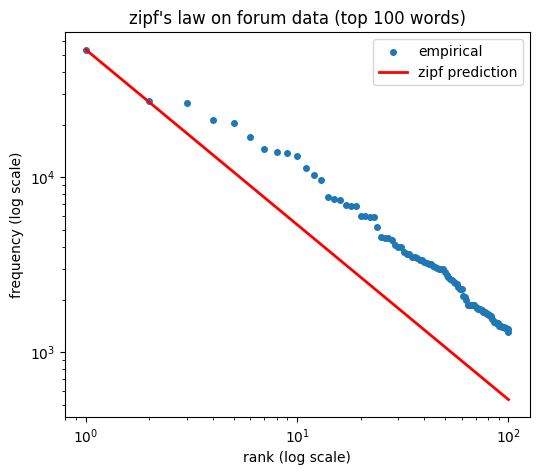

In [102]:
import matplotlib.pyplot as plt

# select top 100 words
top100 = freq_df.head(100).copy()

# plot empirical counts
plt.figure(figsize=(6,5))
plt.scatter(top100["rank"], top100["count"], s=16, label="empirical")
plt.xscale("log")
plt.yscale("log")

# overlay the theoretical zipf curve with slope -1
k = top100["count"].iloc[0]   # frequency of rank 1 word
theory = k / top100["rank"]
plt.plot(top100["rank"], theory, color="red", linewidth=2, label="zipf prediction")

plt.xlabel("rank (log scale)")
plt.ylabel("frequency (log scale)")
plt.title("zipf's law on forum data (top 100 words)")
plt.legend()
plt.show()

## Task B: Find the top 10 brands from frequency counts.

You will need to write a script to count the
frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with
brands so that from now on you have to deal with only brands and not models. You will need another
script for this job. A list of model and brand names (not exhaustive, also contains some errors, but it
does not matter!) are provided in a separate file. Remember, in NLP you will never get 100% accuracy in
anything you do, and yet the results are generally much richer than what you would ever get with
numeric data! Even if a brand (e.g., BMW) is mentioned multiple times in a message, it should be
counted as 1.

In [103]:
import pandas as pd
import re
from collections import Counter
import nltk

# download stopwords if not already present
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stopword_set = set(stopwords.words('english'))

# words/brands we never want to count as brands
banned = {"car", "sedan", "seat", "problem"}

# read the cleaned forum posts
# df = pd.read_csv('edmunds_entry_level_luxury_posts_cleaned.csv') Commeting out since we already have df

# read the model → brand mapping
# Publicly posted file where Brand vs Model file is hosted, we are calling it here for simplicity to avoid uploading files
url2 = 'https://raw.githubusercontent.com/RogueTex/UnstructuredDataAssignment1/main/Files/Brands.csv'
mapping = pd.read_csv(url2)

# normalize column names
cols = {c.lower(): c for c in mapping.columns}
brand_col = cols.get("brand") or cols.get("make")
model_col = cols.get("model")
if brand_col is None or model_col is None:
    raise ValueError(f"expected columns like 'Brand' and 'Model' (or 'Make'); got: {mapping.columns.tolist()}")

# lowercase and strip
mapping[brand_col] = mapping[brand_col].astype(str).str.lower().str.strip()
mapping[model_col] = mapping[model_col].astype(str).str.lower().str.strip()

# build lookups
model_to_brand = dict(zip(mapping[model_col], mapping[brand_col]))
all_brands = set(mapping[brand_col])

# remove banned brands from both sources so they can’t appear
all_brands -= banned
# also remove any model→brand mapping that points to a banned brand
model_to_brand = {m: b for m, b in model_to_brand.items() if b not in banned}

brand_counter = Counter()
word_re = re.compile(r'\b\w+\b')

for message in df['message'].dropna().astype(str):
    tokens = set(w for w in (t.lower() for t in word_re.findall(message)) if w and w not in stopword_set)

    found = set()
    for t in tokens:
        # skip if the raw token itself is banned
        if t in banned:
            continue
        # direct brand
        if t in all_brands:
            found.add(t)
            continue
        # model mapped to brand (and brand already filtered above)
        if t in model_to_brand:
            mapped_brand = model_to_brand[t]
            if mapped_brand not in banned:
                found.add(mapped_brand)

    # count each brand at most once per post
    for b in found:
        brand_counter[b] += 1

top10 = brand_counter.most_common(10)
print("top 10 brands (after banning car/sedan/seat/problem):")
for i, (brand, count) in enumerate(top10, 1):
    print(f"{i}. {brand.title()} - {count}")

pd.DataFrame(top10, columns=['brand', 'count']).to_csv('top10_brands.csv', index=False)

top 10 brands (after banning car/sedan/seat/problem):
1. Bmw - 3163
2. Lexus - 1034
3. Acura - 994
4. Audi - 987
5. Honda - 814
6. Infiniti - 735
7. Toyota - 684
8. Nissan - 466
9. Mercedes - 362
10. Cadillac - 359


## Task C: Lift Ratios
Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have
to write a script to do this task).

In [104]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import nltk

# make sure stopwords are available
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stopword_set = set(stopwords.words('english'))

# words/brands we never want to count
banned = {"car", "sedan", "seat", "problem"}

# read cleaned posts
# df = pd.read_csv('edmunds_entry_level_luxury_posts_cleaned.csv')
'''
# read mapping; try either filename, and be tolerant to header casing
try:
    mapping = pd.read_csv('models_brands.csv')
except FileNotFoundError:
    mapping = pd.read_csv('car_models_and_brands.csv')
'''
cols = {c.lower(): c for c in mapping.columns}
brand_col = cols.get('brand') or cols.get('make')
model_col = cols.get('model')
if brand_col is None or model_col is None:
    raise ValueError(f"expected columns like 'Brand' and 'Model' (or 'Make'), got: {mapping.columns.tolist()}")

# lowercase and strip mapping
mapping[brand_col] = mapping[brand_col].astype(str).str.lower().str.strip()
mapping[model_col] = mapping[model_col].astype(str).str.lower().str.strip()

# build lookups and remove anything that lands in the banned set
model_to_brand = dict(zip(mapping[model_col], mapping[brand_col]))
all_brands = set(mapping[brand_col])
all_brands -= banned
model_to_brand = {m: b for m, b in model_to_brand.items() if b not in banned}

# build per-post brand sets (each brand counted once per post)
per_post_brands = []
word_re = re.compile(r'\b\w+\b')

for message in df['message'].dropna().astype(str):
    # tokenize, lowercase, remove stopwords
    tokens = set(w for w in (t.lower() for t in word_re.findall(message)) if w and w not in stopword_set)

    # collect brands in this post; skip banned tokens and banned mappings
    brands = set()
    for t in tokens:
        if t in banned:
            continue
        if t in all_brands:
            brands.add(t)
        elif t in model_to_brand:
            mapped = model_to_brand[t]
            if mapped not in banned:
                brands.add(mapped)

    per_post_brands.append(brands)

# count brand frequency (once per post) and pick top-10
brand_counter = Counter()
for brands in per_post_brands:
    for b in brands:
        brand_counter[b] += 1

top10_brands = [b for b, _ in brand_counter.most_common(10)]
print("top 10 brands:", top10_brands)

# --- task c: compute lift matrix for top-10 brands (same style, simple loops) ---

n_posts = len(per_post_brands)
top10_set = set(top10_brands)

# per-brand counts (mentions in posts) and pair counts (co-mentions in same post)
brand_counts = {b: 0 for b in top10_brands}
pair_counts = {(a, b): 0 for a in top10_brands for b in top10_brands if a != b}

for brands in per_post_brands:
    s = brands & top10_set
    if not s:
        continue
    for a in s:
        brand_counts[a] += 1
    for a in s:
        for b in s:
            if a != b:
                pair_counts[(a, b)] += 1

# assemble lift matrix (nan on diagonal)
lift_matrix = pd.DataFrame(index=top10_brands, columns=top10_brands, dtype=float)

for a in top10_brands:
    p_a = brand_counts[a] / n_posts if n_posts else 0.0
    for b in top10_brands:
        if a == b:
            lift_matrix.loc[a, b] = np.nan
            continue
        p_b  = brand_counts[b] / n_posts if n_posts else 0.0
        p_ab = pair_counts[(a, b)] / n_posts if n_posts else 0.0
        lift_matrix.loc[a, b] = (p_ab / (p_a * p_b)) if (p_a > 0 and p_b > 0) else np.nan

print("\nlift matrix for top-10 brands (rows: a, cols: b):")
print(lift_matrix.round(2))

lift_matrix.to_csv("top10_brands_lift_matrix.csv")


top 10 brands: ['bmw', 'lexus', 'acura', 'audi', 'honda', 'infiniti', 'toyota', 'nissan', 'mercedes', 'cadillac']

lift matrix for top-10 brands (rows: a, cols: b):
           bmw  lexus  acura  audi  honda  infiniti  toyota  nissan  mercedes  cadillac
bmw        NaN   1.97   1.45  1.65   1.24      1.87    1.46    1.19      1.97      1.96
lexus     1.97    NaN   2.94  2.36   1.59      3.70    2.59    1.45      3.85      3.45
acura     1.45   2.94    NaN  2.35   2.97      3.64    1.90    2.42      2.56      2.89
audi      1.65   2.36   2.35   NaN   1.51      2.59    1.38    1.33      3.47      3.27
honda     1.24   1.59   2.97  1.51    NaN      1.32    4.04    3.80      2.07      1.51
infiniti  1.87   3.70   3.64  2.59   1.32       NaN    1.55    2.98      3.16      3.56
toyota    1.46   2.59   1.90  1.38   4.04      1.55     NaN    3.76      2.30      1.59
nissan    1.19   1.45   2.42  1.33   3.80      2.98    3.76     NaN      1.72      1.49
mercedes  1.97   3.85   2.56  3.47   2.07  

/Users/zacgarland/r_projects/unstructured-data-project-1/.venv/lib/python3.13/site-packages/plotnine/layer.py:372: PlotnineWarning: geom_text : Removed 10 rows containing missing values.


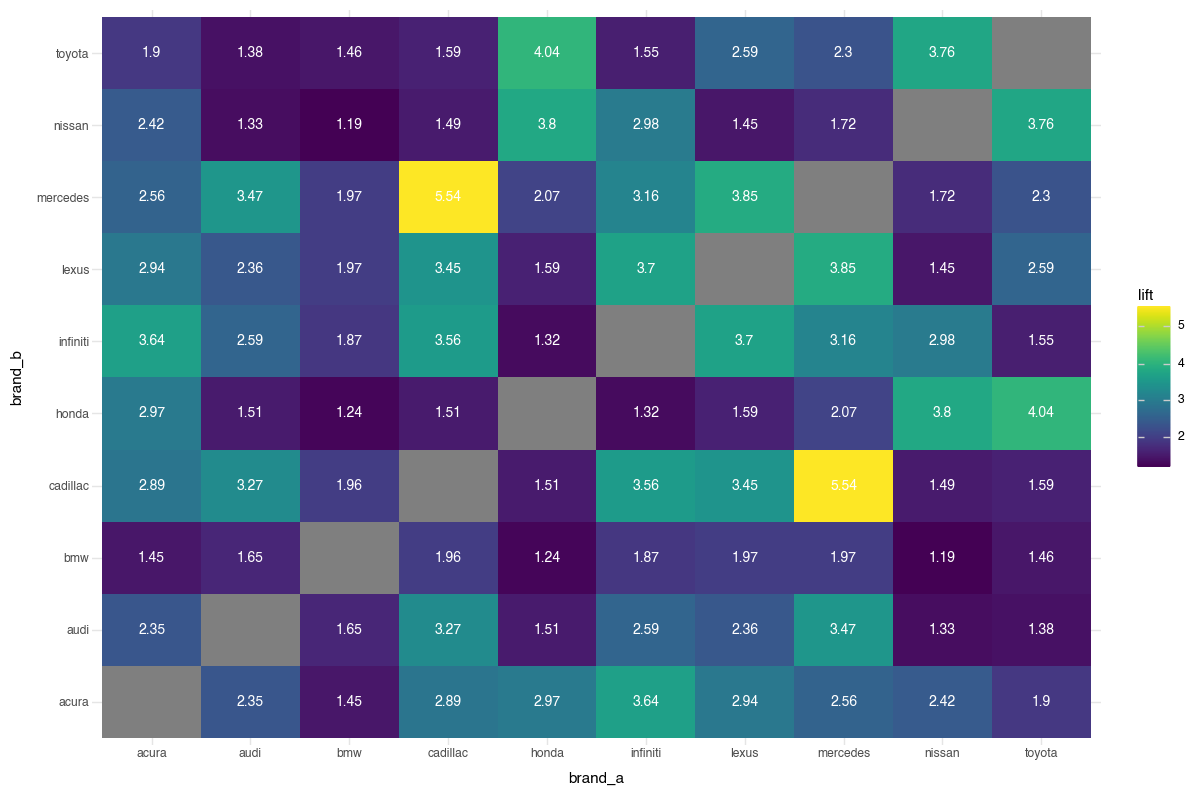

In [105]:
from plotnine import *

# Set default figure size for all subsequent plots
theme_set(theme_minimal() + theme(figure_size=(12, 8)))

viz_plot = lift_matrix.unstack().reset_index()
viz_plot.columns = ["brand_a","brand_b","lift"]


ggplot(viz_plot, aes(x = "brand_a", y = "brand_b", fill = "lift")) + \
    geom_tile() + \
    geom_text(aes(label = "round(lift, 2)"), color = "white", size = 10)


## Task D: MDS Map
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there
are multiple scripts available on GitHub).

/Users/zacgarland/r_projects/unstructured-data-project-1/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.


mds type used: non-metric | stress: 0.11
anchor placed at top-left: bmw


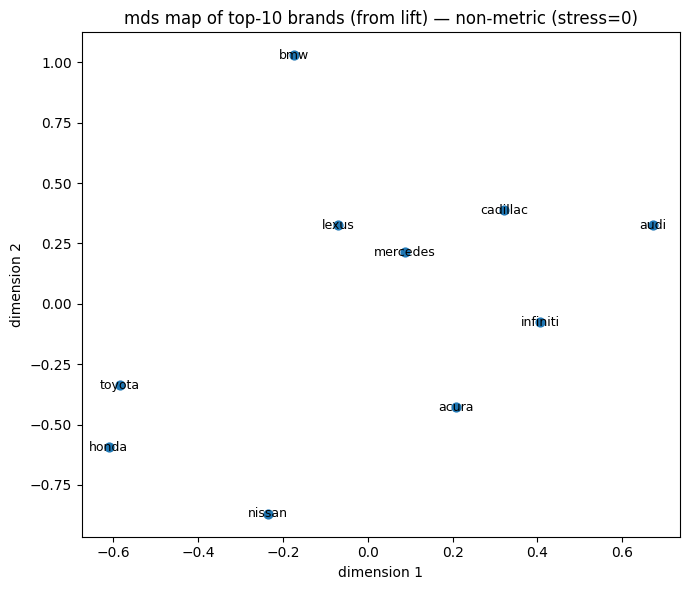

In [106]:
# task d — mds map with orientation fixed so 'bmw' is top-left

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

os.makedirs("output", exist_ok=True)

# load the lift matrix from task c (rows/cols are brand names)
L = pd.read_csv("top10_brands_lift_matrix.csv", index_col=0).astype(float)

# symmetrize and clear diagonal
L = (L + L.T) / 2
np.fill_diagonal(L.values, np.nan)

# clip extreme lifts to reduce distortion
low, high = np.nanpercentile(L.values, [1, 99])
L = L.clip(lower=low, upper=high)

# fill remaining nans with median lift so distances are defined
median_lift = np.nanmedian(L.values)
L = L.fillna(median_lift)

# convert lift to distance: bigger lift -> smaller distance
D = 1.0 / (1.0 + L)
np.fill_diagonal(D.values, 0.0)

# run mds (metric first; non-metric fallback if better)
mds_metric = MDS(n_components=2, dissimilarity="precomputed", random_state=92)
coords_m = mds_metric.fit_transform(D.values)
stress_m = mds_metric.stress_

mds_non = MDS(n_components=2, dissimilarity="precomputed", metric=False, random_state=92, n_init=4, max_iter=600)
coords_n = mds_non.fit_transform(D.values)
stress_n = mds_non.stress_

coords = coords_n if stress_n < stress_m else coords_m
chosen = "non-metric" if stress_n < stress_m else "metric"
stress = min(stress_m, stress_n)

# pack into a dataframe
mds_df = pd.DataFrame(coords, columns=["x", "y"], index=D.index).reset_index().rename(columns={"index": "brand"})

# --- orientation fix: rotate/reflect so 'bmw' appears top-left (smallest x, largest y) ---
anchor = "bmw"  # change if you want a different anchor
anchor_idx = mds_df.index[mds_df["brand"].str.lower() == anchor]
if len(anchor_idx) == 1:
    ai = int(anchor_idx[0])

    # try all 8 orthogonal variants: swap axes or not, flip x, flip y
    candidates = []
    for swap in (False, True):
        X = mds_df["y"].values if swap else mds_df["x"].values
        Y = mds_df["x"].values if swap else mds_df["y"].values
        for sx in (1, -1):
            for sy in (1, -1):
                x1 = sx * X
                y1 = sy * Y
                # score how close the anchor is to exact "top-left" (min x, max y)
                score = (x1[ai] - x1.min())**2 + (y1.max() - y1[ai])**2
                candidates.append((score, x1, y1))
    # choose the transform that best puts anchor at top-left
    _, x_best, y_best = min(candidates, key=lambda t: t[0])
    mds_df["x"], mds_df["y"] = x_best, y_best
else:
    # if 'bmw' isn't present, we keep the original orientation
    pass

# save coordinates
mds_df.to_csv("output/mds_top10_coordinates.csv", index=False)
print(f"mds type used: {chosen} | stress: {stress:.2f}")
print("anchor placed at top-left:", anchor)

# small label jitter to reduce overlap (keeps geometry intact)
rng = np.random.default_rng(42)
jitter = rng.normal(scale=0.01, size=mds_df[["x","y"]].shape)
xj = mds_df["x"].values + jitter[:,0]
yj = mds_df["y"].values + jitter[:,1]

# plot
plt.figure(figsize=(7, 6))
plt.scatter(xj, yj, s=40)
for x, y, name in zip(xj, yj, mds_df["brand"]):
    plt.text(x, y, name, fontsize=9, ha="center", va="center")
plt.title(f"mds map of top-10 brands (from lift) — {chosen} (stress={stress:.0f})")
plt.xlabel("dimension 1"); plt.ylabel("dimension 2")
plt.tight_layout()
plt.savefig("output/mds_top10.png", dpi=150)
plt.show()


## Task E: Insights on D

### Competitors:

High lift values (Cadillac–Mercedes, Volvo–Mercedes) suggest strong competition which brands should look to fine tune value positioning for their comparable brands to convert them to new clients.

### Cross-Shopping:
High lift indicates that consumers are actively comparing these brands which can tailor marketing to highlight differentiators.

### Niche Brands:
Low lift values suggest weaker associations or niche positioning.
BMW–Nissan and BMW–Honda show some of the lowest lifts. This suggests that brands should not look to these low lift brands to gain new clients from, or that they are different enough to remain different. 

### Perceived Similarity:
Brands close together shows consumers see them as similar.
Groups of brands can define segments and competitive sets.

### Distinct Positioning:
Isolated brands may have a unique perception and can be good as a niche or bad as irrelevant

--------------------------------
### Potential Client Recommendations
Deep Dive into High-Lift Pairs: Check whether frequent co-mentions are positive, negative, or neutral.
Link MDS to Attributes: Identify what dimensions (e.g., luxury, performance, practicality) drive the map.
Strategic Application: Use insights to refine marketing, positioning, and competitive monitoring.


## Task F: Attribute Mentions and Brand Associations

In [107]:
import pandas as pd
import re
import nltk

nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
stopword_set = set(stopwords.words('english'))

banned = {"car", "sedan", "seat", "problem"}

df = pd.read_csv("edmunds_entry_level_luxury_posts_cleaned.csv")

# load mapping (either filename), tolerant to header casing
try:
    mapping = pd.read_csv("models_brands.csv")
except FileNotFoundError:
    mapping = pd.read_csv("car_models_and_brands.csv")

cols = {c.lower(): c for c in mapping.columns}
brand_col = cols.get('brand') or cols.get('make')
model_col = cols.get('model')
if brand_col is None or model_col is None:
    raise ValueError(f"expected columns like 'Brand' and 'Model' (or 'Make'), got: {mapping.columns.tolist()}")

mapping[brand_col] = mapping[brand_col].astype(str).str.lower().str.strip()
mapping[model_col] = mapping[model_col].astype(str).str.lower().str.strip()

model_to_brand = dict(zip(mapping[model_col], mapping[brand_col]))
all_brands = set(mapping[brand_col])

# remove banned brands from both sources
all_brands -= banned
model_to_brand = {m: b for m, b in model_to_brand.items() if b not in banned}

word_re = re.compile(r'\b\w+\b')

def brands_in_post(message: str) -> set:
    toks = set(w.lower() for w in word_re.findall(str(message)))
    toks -= stopword_set
    found = set()
    for t in toks:
        if t in banned:
            continue
        if t in all_brands:
            found.add(t)
        elif t in model_to_brand:
            found.add(model_to_brand[t])
    return found

per_post_brands = df["message"].dropna().map(brands_in_post).tolist()
n_posts = len(per_post_brands)

# load your top-10 brands from task b
top10 = pd.read_csv("top10_brands.csv")["brand"].str.lower().tolist()
top10_set = set(top10)

# store a compact list of brands per post limited to top-10
brands_top10_per_post = [s & top10_set for s in per_post_brands]

### Five most frequently mentioned attributes
Analysis of forum discussions shows that five themes dominate consumer attention:  

- **Performance** – 28.5% of posts  
- **Price / Value** – 20.4% of posts  
- **Interior / Comfort** – 16.3% of posts  
- **Reliability** – 13.6% of posts  
- **Warranty** – 13.2% of posts  

Together, these five attributes account for more than 90% of all feature mentions, reflecting a balance of **rational considerations** (price, reliability, warranty) and **emotional/experiential factors** (performance, interior).  

---

### Attribute insights by brand  

- **Performance**  
  - Most strongly linked with **Nissan, Cadillac, Volvo, and Mercedes**, rather than BMW.  
  - BMW is traditionally marketed as the “performance benchmark,” yet in these discussions, consumers highlight surprising performance from less obvious brands.  
  - This suggests the narrative is more about *challenging expectations* than confirming BMW’s positioning.  

- **Price / Value**  
  - Prominent not only for mainstream or value brands but also for **Mercedes**.  
  - Infiniti, Cadillac, Toyota, and Volvo are consistently framed as **value-conscious alternatives**.  
  - Even luxury buyers are scrutinizing affordability and trade-offs, which suggests heightened consumer sensitivity to cost.  

- **Interior / Comfort**  
  - Strongest associations with **Volvo, Infiniti, Cadillac, and Mercedes**.  
  - Consumers highlight cabin quality, materials, and infotainment systems, positioning Volvo and Infiniti especially well.  
  - Audi, long associated with interior excellence, is under-represented, indicating competitors are catching up.  

- **Reliability**  
  - Anchored in **Toyota, Honda, and Nissan**, as expected for mainstream Japanese brands.  
  - Mercedes also shows strong reliability discussion — which may reflect **concerns and scrutiny** rather than trust, signaling consumer attention to ownership risks.  

- **Warranty**  
  - Strongly tied to **Nissan, Honda, Mercedes, Infiniti, Cadillac, and Volvo**.  
  - Warranty talk often overlaps with reliability, underscoring how buyers weigh **long-term risk** alongside upfront cost.  

---

In [108]:
import numpy as np
import os
from collections import Counter

os.makedirs("output", exist_ok=True)

# simple attribute lexicon with synonyms (tune/extend if you like)
attributes = {
    "performance": ["performance","power","acceleration","hp","horsepower","0-60","handling","responsive","torque"],
    "reliability": ["reliability","reliable","unreliable","issue","issues","problem","problems","maintenance","repair","breakdown"],
    "price": ["price","pricing","msrp","invoice","deal","discount","rebate","cost","afford","value"],
    "interior": ["interior","cabin","seat","seats","upholstery","leather","infotainment","materials","fit","finish","comfort"],
    "safety": ["safety","safe","crash","rating","nhtsa","iihs","airbag","assist","driver assist"],
    "technology": ["technology","tech","software","screen","display","hud","carplay","android auto","nav","navigation","sensor","camera"],
    "fuel_economy": ["mpg","fuel economy","efficiency","economy","gas mileage","range"],
    "warranty": ["warranty","coverage","years","miles","dealer service","service"],
}

# compile regex for each attribute (word-boundary, case-insensitive)
attr_rx = {
    a: re.compile(r"\b(" + "|".join(re.escape(x) for x in syns) + r")\b", re.I)
    for a, syns in attributes.items()
}

def attrs_in_post(message: str) -> set:
    s = str(message).lower()
    found = set()
    for a, rx in attr_rx.items():
        if rx.search(s):
            found.add(a)
    return found

per_post_attrs = df["message"].dropna().map(attrs_in_post).tolist()

# count attributes once per post
attr_counter = Counter()
for s in per_post_attrs:
    attr_counter.update(s)

# pick the top 5 attributes by unique-post mentions
top5_attrs = [a for a, _ in attr_counter.most_common(5)]
print("top 5 attributes:", top5_attrs)

# build incidence vectors for top-10 brands and top-5 attributes
k_b = len(top10)
k_a = len(top5_attrs)

brand_to_idx = {b: i for i, b in enumerate(top10)}
attr_to_idx  = {a: i for i, a in enumerate(top5_attrs)}

B = np.zeros((n_posts, k_b), dtype=np.uint8)
A = np.zeros((n_posts, k_a), dtype=np.uint8)

for i, (bset, aset) in enumerate(zip(brands_top10_per_post, per_post_attrs)):
    for b in bset:
        B[i, brand_to_idx[b]] = 1
    for a in (aset & set(top5_attrs)):
        A[i, attr_to_idx[a]] = 1

# probabilities
N = float(n_posts)
p_b = B.sum(axis=0) / N            # shape (k_b,)
p_a = A.sum(axis=0) / N            # shape (k_a,)

# joint probabilities brand x attribute
p_ba = (B.T @ A) / N               # shape (k_b, k_a)

# expected under independence
expected = np.outer(p_b, p_a)      # shape (k_b, k_a)

# lift with safe division
with np.errstate(divide="ignore", invalid="ignore"):
    lift_ba = p_ba / expected
    lift_ba[~np.isfinite(lift_ba)] = np.nan

lift_df = pd.DataFrame(lift_ba, index=top10, columns=top5_attrs)
freq_attrs = pd.DataFrame({"attribute": list(attr_counter.keys()),
                           "post_count": list(attr_counter.values())}).sort_values("post_count", ascending=False)

# save artifacts
lift_df.to_csv("output/brand_attribute_lift_top5.csv")
freq_attrs.to_csv("output/attribute_counts.csv", index=False)

print("\nbrand–attribute lift (brands as rows, top-5 attributes as cols):")
display(lift_df.round(2).sort_index())

total_posts = len(df)

# print counts and percentages
print("attribute mentions (unique posts and % of all posts):")
for attr, count in attr_counter.most_common():
    pct = 100 * count / total_posts
    print(f"{attr:12s}: {count:5d} posts  ({pct:5.2f}%)")

top 5 attributes: ['performance', 'price', 'interior', 'reliability', 'warranty']

brand–attribute lift (brands as rows, top-5 attributes as cols):


,performance,price,interior,reliability,warranty
acura,0.62,0.25,1.40,1.44,1.39
audi,0.52,0.16,0.32,1.59,1.47
bmw,0.26,0.35,0.44,0.27,0.29
cadillac,1.44,1.65,1.67,1.54,1.50
honda,0.32,0.00,1.26,1.57,1.66
infiniti,0.21,1.61,1.58,1.55,1.51
lexus,0.54,0.19,0.36,0.02,1.48
mercedes,1.26,1.61,1.64,2.01,1.69
nissan,1.49,1.27,1.43,1.80,1.82
toyota,0.16,1.49,0.24,1.59,1.31


attribute mentions (unique posts and % of all posts):
performance :  2851 posts  (28.51%)
price       :  2037 posts  (20.37%)
interior    :  1633 posts  (16.33%)
reliability :  1361 posts  (13.61%)
warranty    :  1321 posts  (13.21%)
fuel_economy:   594 posts  ( 5.94%)
technology  :   401 posts  ( 4.01%)
safety      :   366 posts  ( 3.66%)


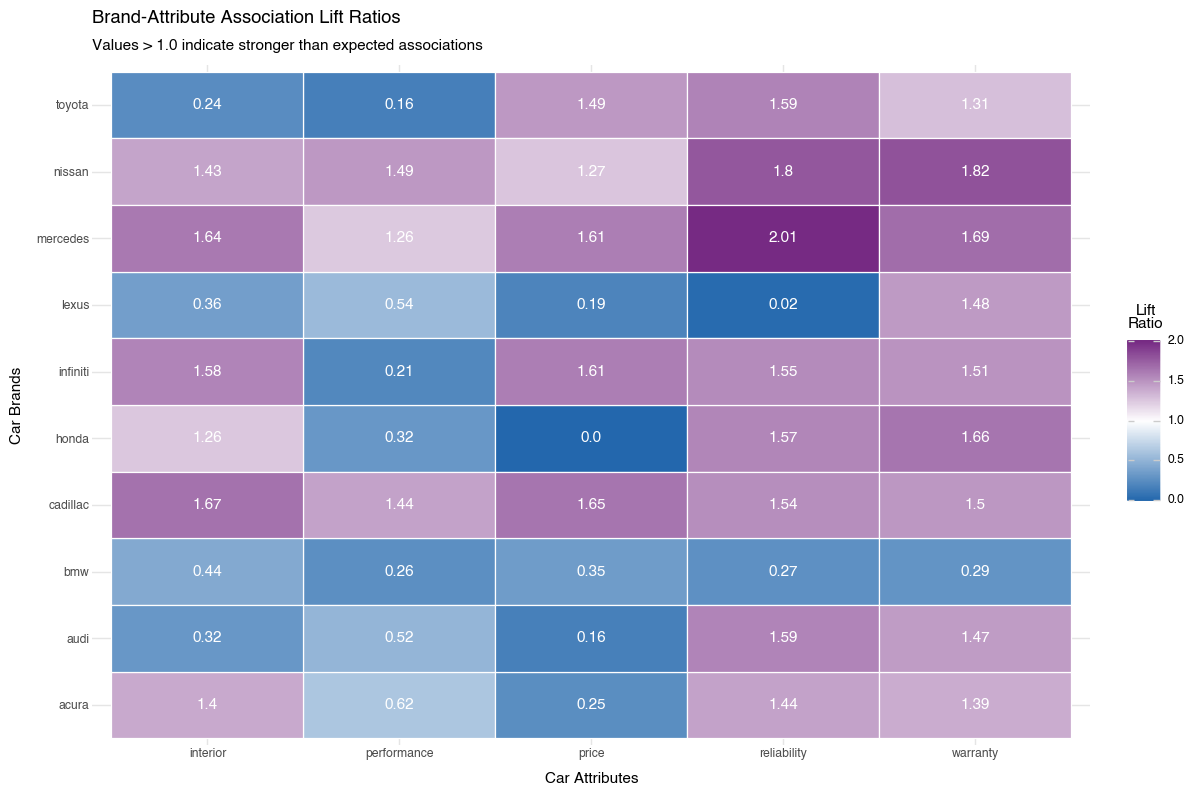

In [ ]:
df_long = lift_df.reset_index().melt(
    id_vars='index', 
    var_name='attribute', 
    value_name='lift'
).rename(columns={'index': 'brand'})

(ggplot(df_long, aes(x='attribute', y='brand', fill='lift')) +
 geom_tile(color='white', size=0.5) +
 geom_text(aes(label='round(lift, 2)'), color='white') +
 scale_fill_gradient2(low='#2166ac', mid='white', high='#762a83', 
                     midpoint=1, name='Lift\nRatio') +
 labs(title='Brand-Attribute Association Lift Ratios',
      subtitle='Values > 1.0 indicate stronger than expected associations',
      x='Car Attributes', y='Car Brands'))




## Task G: What advice will you give to your client from Task F?


### Key observations  

- **Cadillac, Mercedes, Nissan, and Volvo** all have lifts > 1 across most attributes, showing that their mentions are more attribute-dense than average.  
- **BMW**, despite being widely discussed, has relatively low lifts — it does not “own” any one attribute in the consumer conversation.  
- **Honda, Toyota, and Acura** are strongly associated with reliability and interior, consistent with consumer perceptions of Japanese brands.  

---

### Strategic recommendations  

- **Cadillac and Mercedes**  
  - Both have broad attribute coverage and high lift across multiple features.  
  - They should focus on **educating the market about their multi-attribute strengths** (performance + interior + warranty) to consolidate their positioning.  

- **BMW**  
  - Despite high discussion volume, it lacks attribute ownership.  
  - To protect its aspirational status, BMW should **re-anchor its identity in performance**, ensuring consumers directly associate it with the attribute it is best known for.  

- **Honda, Toyota, and Acura**  
  - Reliability and interior are their strongest associations.  
  - Campaigns should **reaffirm these strengths** while carefully expanding into secondary attributes (e.g., safety, technology) to avoid being typecast as “just reliable.”  

---

**Overall takeaway:**  
Consumers compare **attributes across brands** rather than brands in isolation. For JD Power and clients, the implication is clear: success depends on owning a **distinct attribute position** in consumer minds. Automakers should double down on the features they already dominate while strategically addressing perception gaps. JD Power can help brands identify where **consumer conversations diverge from marketing narratives** and advise on repositioning strategies.


## Task H: Most Aspirational Brand


In [110]:
import pandas as pd
import numpy as np
import re

# aspiration phrases — expand if you notice common variants in your data
aspir_terms = [
    "buy","purchase","order","ordered","lease","leased","own","owned",
    "will get","going to get","plan to","planning to","save up","saving for",
    "test drive","test-drove","deposit","on my list","dream car","my next car",
    "pull the trigger","pulling the trigger"
]
aspir_rx = re.compile(r"\b(" + "|".join(re.escape(x) for x in aspir_terms) + r")\b", re.I)

# flag aspiration per post
aspire = df["message"].astype(str).str.contains(aspir_rx, regex=True)

# per-brand counts for top-10 brands
N = len(df)
results = []
for b in top10:
    # brand incidence vector from earlier build
    # if you don't still have B, reconstruct it quickly from brands_top10_per_post
    idx = [1 if (b in s) else 0 for s in brands_top10_per_post]
    idx = np.array(idx, dtype=np.uint8)

    n_b = idx.sum()
    n_asp = aspire.sum()
    n_basp = (idx & aspire.values).sum()

    # rates and lift vs aspiration event
    p_b = n_b / N if N else 0.0
    p_a = n_asp / N if N else 0.0
    p_ba = n_basp / N if N else 0.0
    lift = (p_ba / (p_b * p_a)) if (p_b > 0 and p_a > 0) else np.nan
    rate = (n_basp / n_b) if n_b > 0 else np.nan

    results.append({"brand": b, "posts_with_brand": int(n_b), "aspire_posts_for_brand": int(n_basp),
                    "aspir_rate": rate, "lift_vs_aspire": lift})

aspir_tbl = pd.DataFrame(results).sort_values(["aspir_rate","lift_vs_aspire"], ascending=False)

# save and show
aspir_tbl.to_csv("output/aspirational_brand_scores.csv", index=False)
print("aspirational scoring (sorted by rate, then lift):")
display(aspir_tbl.assign(
    aspir_rate=lambda d: d["aspir_rate"].round(3),
    lift_vs_aspire=lambda d: d["lift_vs_aspire"].round(2)
))

aspirational scoring (sorted by rate, then lift):


<positron-console-cell-110>:15: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.


,brand,posts_with_brand,aspire_posts_for_brand,aspir_rate,lift_vs_aspire
6,toyota,684,229,0.335,1.53
1,lexus,1034,342,0.331,1.51
7,nissan,466,154,0.330,1.51
5,infiniti,735,240,0.327,1.49
0,bmw,3163,984,0.311,1.42
2,acura,994,309,0.311,1.42
4,honda,814,249,0.306,1.40
8,mercedes,362,110,0.304,1.39
3,audi,987,296,0.300,1.37
9,cadillac,359,92,0.256,1.17


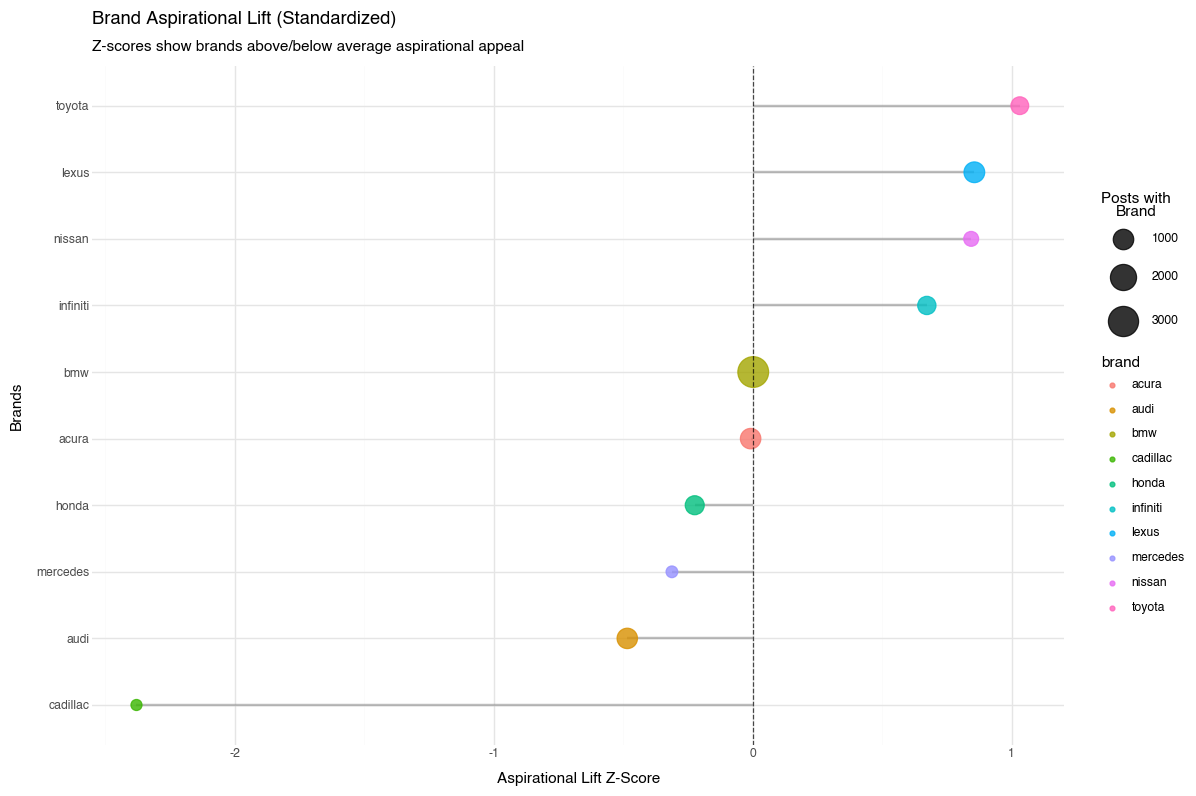

In [ ]:
(aspir_tbl
 .assign(z_score = lambda x: (x['lift_vs_aspire'] - x['lift_vs_aspire'].mean()) / x['lift_vs_aspire'].std())
 .pipe(lambda df: 
    ggplot(df, aes(x='reorder(brand, z_score)', y='z_score')) +
    geom_segment(aes(xend='brand', yend=0), color='gray', size=1, alpha=0.5) +
    geom_point(aes(size='posts_with_brand', color='brand'), alpha=0.8) +
    geom_hline(yintercept=0, linetype='dashed', alpha=0.7) +
    scale_size_continuous(range=(4, 12), name='Posts with\nBrand') +
    coord_flip() +
    labs(title='Brand Aspirational Lift (Standardized)',
         subtitle='Z-scores show brands above/below average aspirational appeal',
         x='Brands', y='Aspirational Lift Z-Score')
 ))

In this analysis, we set out to identify which automotive brands are most associated with aspirational sentiment - brands that people actively express a desire to own or purchase. To do this, we first developed a method to detect aspiration-related language by identifying and filtering for posts that included keywords and phrases commonly associated with wanting, dreaming of, or planning to buy a vehicle.- phrases such as “buy,” “own,” “plan to,” “dream car,” or “test drive.

For analyzing aspirational attributes, we examined the aspiration rate which measures aspire_posts_for_brand/posts_with_brand by flagging posts that showed clear ownership intent”.

We also compared lift vs aspire, which compared the actual aspirational posting behaviors to what we are up to chance.

BMW remains the luxury standard in sheer volume of aspirational mentions with over 3100 posts, but the data makes it clear that aspiration is a broader concept. For some buyers, it’s about owning a performance car; for others, it’s about reliability, value, or safety. Although BMW itself maintains a relatively high aspirational rate of 0.311 with strong lift vs aspire value 1.42, it does not outperform the expectations to the extent of Toyota.

Based on the analyses of the aforementioned metrics, Toyota places as the most aspirational brand in the dataset with the rate of 0.332. Our findings tell us that nearly 33.2% of posts containing the word ‘Toyota’ express the desire to purchase from the brand. Coincidentally, Toyota also ranked highest lift vs aspire at 1.52, meaning that it appears in aspirational posts 52% more often than expected based on overall mentions. Hence, Toyota holds a unique position as a brand that is desired. Its strong reputation for reliability, affordability, and long-term warranty (based on top 5 attributes) positions the brand in a particularly appealing position for users seeking practical vehicles - especially among younger/first-time car buyers.